# Проект "Определение возраста покупателей. Компьютерное зрение."

## Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

### Инструкция по выполнению проекта

1. Проведите исследовательский анализ набора фотографий.
2. Подготовьте данные к обучению.
3. Обучите нейронную сеть и рассчитайте её качество.

# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
# Загружаем данные
path = '/datasets/faces/'
labels = pd.read_csv(path + 'labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=42)
features, target = next(gen_flow)

Found 7591 validated image filenames.


In [3]:
#Узнаем общие сведения о данных, их размер, тип
print(labels.info())
print("Размер таблицы\n", labels.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None
Размер таблицы
 (7591, 2)


In [4]:
# Посмотрим сколько всего пропусков, %
display(pd.DataFrame(round(labels.isna().mean()*100, )).style.background_gradient('coolwarm'))

,0
file_name,0.000000
real_age,0.000000


          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000


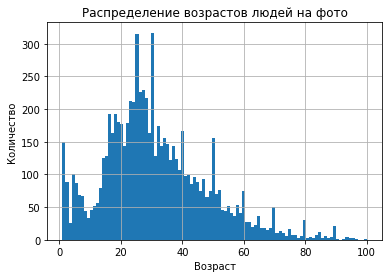

In [5]:
#Посмотрим на характеристики и распределение целевого признака. Отрисуем гисторгамму.
print(labels.describe())
labels['real_age'].hist(bins=100).set(xlabel='Возраст', ylabel='Количество')
plt.title('Распределение возрастов людей на фото')    
plt.show()

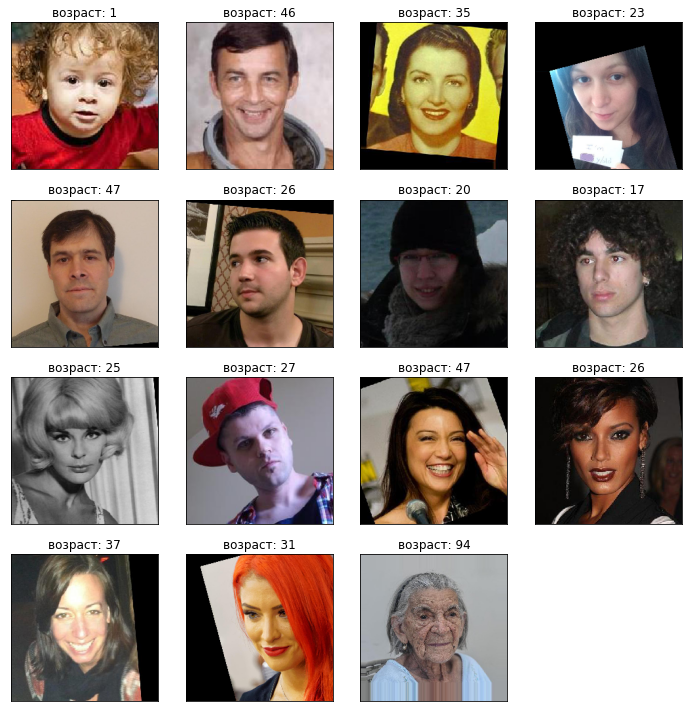

In [6]:
#Выводим 15 фоток. Столько требуется по условию проекта
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title('возраст: ' + str(target[i]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Вывод: Имеем не очень большой дадасет (7500 записей). Тип дынных целевого признака верный – int64, пропусков нет. Распределение целевого признака покаывает, что основная часть фото относится к возрасту 20-40 лет. На графике также видны пики каждые 10 лет. Возможно, это связано с тем, что датасет собирался из нескольких частей, некоторые из которых классифицировались по десяткам лет.
Качество фото разное, есть и черно-белые, есть кропнутые, есть фото со снимков. Все это усложнит обучение модели.**

## Обучение модели

```python
import pandas as pd
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

def load_train(path):
    data = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.2, rescale = 1./255)
    gen_flow = datagen.flow_from_dataframe(
                        dataframe = data,
                        directory = path + '/final_files/',
                        x_col = 'file_name',
                        y_col = 'real_age',
                        target_size = (224, 224),
                        batch_size = 32,
                        class_mode = 'raw',
                        subset = 'training',
                        seed = 42, horizontal_flip=True

                        )
    return gen_flow

def load_test(path):
    data = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.2, rescale = 1./255)
    gen_flow = datagen.flow_from_dataframe(
                        dataframe = data,
                        directory = path + '/final_files/',
                        x_col = 'file_name',
                        y_col = 'real_age',
                        target_size = (224, 224),
                        batch_size = 32,
                        class_mode = 'raw',
                        subset = 'validation',
                        seed = 42
                        )
    return gen_flow

def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer = optimizer, loss='mse', metrics=['mae'])
    return model

def train_model(model, train_data, test_data, epochs=5, steps_per_epoch=None, validation_steps=None, batch_size=None):
    steps_per_epoch = len(train_data) if steps_per_epoch else None
    validation_steps = len(test_data) if validation_steps else None
    model.fit(train_data,
              validation_data = test_data,
              batch_size = batch_size, 
              epochs = epochs,
              steps_per_epoch = steps_per_epoch,
              validation_steps = validation_steps,
              verbose = 2
              )

    return model

```

```
Train for 190 steps, validate for 48 steps
Epoch 1/5
2023-03-22 12:32:36.080283: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-03-22 12:32:36.488140: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
190/190 - 63s - loss: 222.9207 - mae: 10.7719 - val_loss: 778.0769 - val_mae: 22.8426
Epoch 2/5
190/190 - 49s - loss: 63.1443 - mae: 6.0513 - val_loss: 744.0282 - val_mae: 22.2228
Epoch 3/5
190/190 - 45s - loss: 31.1481 - mae: 4.2700 - val_loss: 419.9064 - val_mae: 15.7817
Epoch 4/5
190/190 - 49s - loss: 19.5018 - mae: 3.4310 - val_loss: 112.9343 - val_mae: 7.9422
Epoch 5/5
190/190 - 51s - loss: 15.0223 - mae: 2.9896 - val_loss: 73.9081 - val_mae: 6.4465
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
48/48 - 9s - loss: 73.9081 - mae: 6.4465
Test MAE: 6.4465

```

**Вывод: Обучили модель с помощью ResNet50 с оптимизатором adam при шаге lr=0.0001. Обучались на 5 эпохах. На тестовой выборке получили MAE=6.44, что является хорошим результатом, так как по условию проекта MAE модели не должно быть больше 8.**

## Анализ обученной модели

В проекте использовали арзхитекруту RESNET50 с 50 слоями. Модель предобучена на датасете imagenet. Изначально веса модели были получены оттуда.
    
Модель обучалась 5 эпохами, размер батчей 32, оптимизатор выбран ADAM c шагом lr=0.0001. Применена аугментация
    
Судя по разнице MAE и LOSS между тренировоной и тестовой выборках, можно сказать, что модель немного переобучена.

Модель показала весьма неплохие результаты, если сравнивать с эталоном http://people.ee.ethz.ch/~timofter/publications/Agustsson-FG-2017.pdf
Датасет сам не лучшего качества. Многие фото скрывают часть лица, что естественно не может не отразиться на качестве обучения модели. Размера датасета в принципе большой, но неравномерный.  Основная масса людей на снимках принадлежит диапозону от 20 до 40 лет, что тоже будет влиять на качество моделей, т.к. до 20 лет и больше 40 не хватает объектов, было бы лучше, если бы возраст был распределен равномерно и фото были лучшего качества. Таким образом, можно сделать вывод, что выборка недостаточно репрезентативна.
Чтобы написать общий вывод, в GPU-тренажёре мной было протестировано несколько вариантов моделей. Например была использована аугментация horizontal_flip, vertical_flip и rotation_range. Методом перебора выяснил, что немного лучший результат дает только горизонтальная аугментация, другие – наоборот, увеличивают время работы модели и снижают метрику. Ниже результат с 3 параметрами аугментации.

    48/48 - 8s - loss: 87.5608 - mae: 7.0260
    Test MAE: 7.0260